In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

In [2]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [3]:

"""The Heisenberg model"""
import logging
import numpy as np
from fractions import Fraction
from typing import Optional

from qiskit_nature.operators.second_quantization import SpinOp
from qiskit_nature.problems.second_quantization.lattice.lattices import Lattice
from qiskit_nature.problems.second_quantization.lattice.models.lattice_model import LatticeModel

class HeisenbergModel(LatticeModel):
    """The Heisenberg model."""

    def coupling_matrix(self) -> np.ndarray:
        """Return the coupling matrix."""
        return self.interaction_matrix()


    @classmethod
    def uniform_parameters(
        cls,
        lattice: Lattice,
        uniform_interaction: complex,
        uniform_onsite_potential: complex,
    ) -> "HeisenbergModel":
        """Set a uniform interaction parameter and on-site potential over the input lattice.

        Args:
            lattice: Lattice on which the model is defined.
            uniform_interaction: The interaction parameter.
            uniform_onsite_potential: The on-site potential.

        Returns:
            The Lattice model with uniform parameters.
        """
        return cls(
            cls._generate_lattice_from_uniform_parameters(
                lattice, uniform_interaction, uniform_onsite_potential
            )
        )


    @classmethod
    def from_parameters(
        cls,
        interaction_matrix: np.ndarray,
    ) -> "HeisenbergModel":
        """Return the Hamiltonian of the Lattice model
        from the given interaction matrix and on-site interaction.

        Args:
            interaction_matrix: A real or complex valued square matrix.

        Returns:
            LatticeModel: The Lattice model generated from the given interaction
                matrix and on-site interaction.

        Raises:
            ValueError: If the interaction matrix is not square matrix, it is invalid.
        """
        return cls(cls._generate_lattice_from_parameters(interaction_matrix))


    def second_q_ops(self, display_format: Optional[str] = None) -> SpinOp:
        """Return the Hamiltonian of the Heisenberg model in terms of `SpinOp`.

        Args:
            display_format: Not supported for Spin operators. If specified, it will be ignored.

        Returns:
            SpinOp: The Hamiltonian of the Heisenberg model.
        """
        if display_format is not None:
            logger.warning(
                "Spin operators do not support display-format. Provided display-format "
                "parameter will be ignored."
            )
        ham = []
        weighted_edge_list = self._lattice.weighted_edge_list
        register_length = self._lattice.num_nodes
        # kinetic terms
        for node_a, node_b, weight in weighted_edge_list:
            if node_a == node_b:
                index = node_a
                ham.append((f"X_{index}", weight))

            else:
                index_left = node_a
                index_right = node_b
                coupling_parameter = weight
                ham.append((f"X_{index_left} X_{index_right}", coupling_parameter))
                ham.append((f"Y_{index_left} Y_{index_right}", coupling_parameter))
                #ham.append((f"Z_{index_left} Z_{index_right}", coupling_parameter))
        return SpinOp(ham, spin=Fraction(1, 2), register_length=register_length)

In [4]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})
from qiskit_nature.second_q.hamiltonians.lattices import (
    BoundaryCondition,
    HyperCubicLattice,
    Lattice,
    LatticeDrawStyle,
    LineLattice,
    SquareLattice,
    TriangularLattice,
)

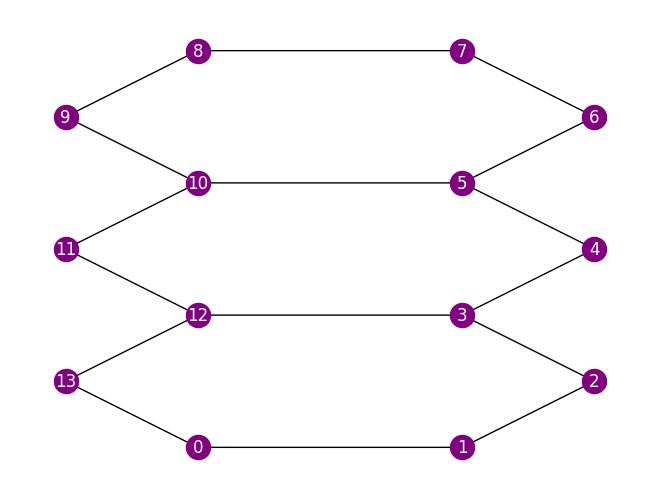

In [5]:
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice
num_sites = 14
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 6, t),
    (6, 7, t),
    (7, 8, t),
    (8, 9, t),
    (9, 10, t),
    (10, 11, t),
    (11, 12, t),
    (12, 13, t),
    (13, 0, t),
    (3, 12, t),
    (5, 10, t),
]

b=0.5
s=np.sqrt(0.75)

graphene_pos = {0:[0,0], 1:[1,0], 2:[1+b,s], 6:[1+b,5*s], 4:[1+b,3*s], 7:[1,6*s], 
              5:[1,4*s], 3:[1,2*s], 8:[0,6*s], 10:[0,4*s], 12:[0,2*s], 13:[-b,s],
              11:[-b,3*s], 9:[-b,5*s],}

"""
kagome_pos = {0:[0,-3], 1:[0,0], 2:[1,0], 3:[1+b,s], 4:[2+b,s], 5:[2+2*b,2*s], 6:[2+b,3*s],
              7:[2+2*b,4*s], 8:[2+b,5*s], 9:[1+b,5*s], 10:[1,6*s], 11:[0,6*s],18:[-b,s],
              12:[-b,5*s], 13:[-(b+1),5*s], 15:[-(b+1),3*s], 17:[-(b+1),s],
              14:[-(2*b+1),4*s], 16:[-(2*b+1),2*s]}
"""

# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
graphene = Lattice(graph)

graphene.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':graphene_pos})
plt.show()

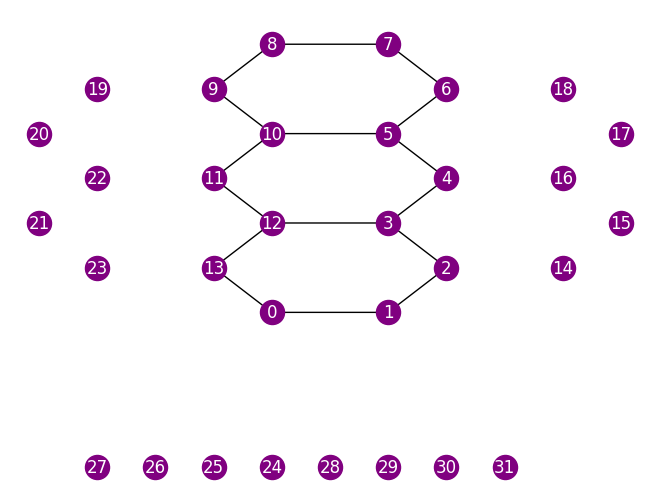

In [6]:
import rustworkx as rx
from qiskit_nature.problems.second_quantization.lattice import Lattice
num_sites = 32
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 6, t),
    (6, 7, t),
    (7, 8, t),
    (8, 9, t),
    (9, 10, t),
    (10, 11, t),
    (11, 12, t),
    (12, 13, t),
    (13, 0, t),
    (3, 12, t),
    (5, 10, t),
]

b=0.5
s=np.sqrt(0.75)

graphene_pos = {0:[0,0], 1:[1,0], 2:[1+b,s], 6:[1+b,5*s], 4:[1+b,3*s], 7:[1,6*s], 
              5:[1,4*s], 3:[1,2*s], 8:[0,6*s], 10:[0,4*s], 12:[0,2*s], 13:[-b,s],
              11:[-b,3*s], 9:[-b,5*s], 14:[2+b,s], 15:[2+2*b,2*s], 16:[2+b,3*s],
              17:[2+2*b,4*s], 18:[2+b,5*s], 19:[-(b+1),5*s], 20:[-(2*b+1),4*s], 21:[-(2*b+1),2*s],
              22:[-(b+1),3*s], 23:[-(b+1),s], 24:[0,-3], 
              25:[-b,-3], 26:[-2*b,-3], 27:[-3*b,-3], 28:[b,-3], 29:[2*b,-3], 30:[3*b,-3], 31:[4*b,-3],}

"""
kagome_pos = {0:[0,-3], 1:[0,0], 2:[1,0], 3:[1+b,s], 4:[2+b,s], 5:[2+2*b,2*s], 6:[2+b,3*s],
              7:[2+2*b,4*s], 8:[2+b,5*s], 9:[1+b,5*s], 10:[1,6*s], 11:[0,6*s],18:[-b,s],
              12:[-b,5*s], 13:[-(b+1),5*s], 15:[-(b+1),3*s], 17:[-(b+1),s],
              14:[-(2*b+1),4*s], 16:[-(2*b+1),2*s]}
"""

# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
graphene1 = Lattice(graph)

graphene1.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':graphene_pos})
plt.show()

In [10]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper
# Build Hamiltonian from graph edges
heis_25 = HeisenbergModel.uniform_parameters(
    lattice=graphene1, # While Computing with NumPyEigensolver REPLACE with 'lattice=graphene' then 
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)
# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
ham_25 = 4 * log_mapper.map(heis_25.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:

ham_25

PauliSumOp(SparsePauliOp(['IIIIIIIIIIIIIIIIIIYYIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIYYIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIYYIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIYYIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIYYIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIYYIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIYYIIIIII', 'IIIIIIIIIIIIIIIIIIIIIYIIIIYIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIYYIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIYYIIII', 'IIIIIIIIIIIIIIIIIIIYIIIIIIIIYIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIYYIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIYYII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIYYI', 'IIIIIIIIIIIIIIIIIIYIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYY', 'IIIIIIIIIIIIIIIIIIXXIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIXXIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIXXIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIXXIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIIIIIIIIIIIXIIIIXIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIIIIIIIXIIIIIIIIXIII', 'I

In [9]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=1)
exact_result = exact_solver.compute_eigenvalues(ham_25)
print(exact_result.eigenvalues)

[-19.73181442]


In [11]:
gs_energy = -19.73181442 #np.round(exact_result.eigenvalues[0], 4)

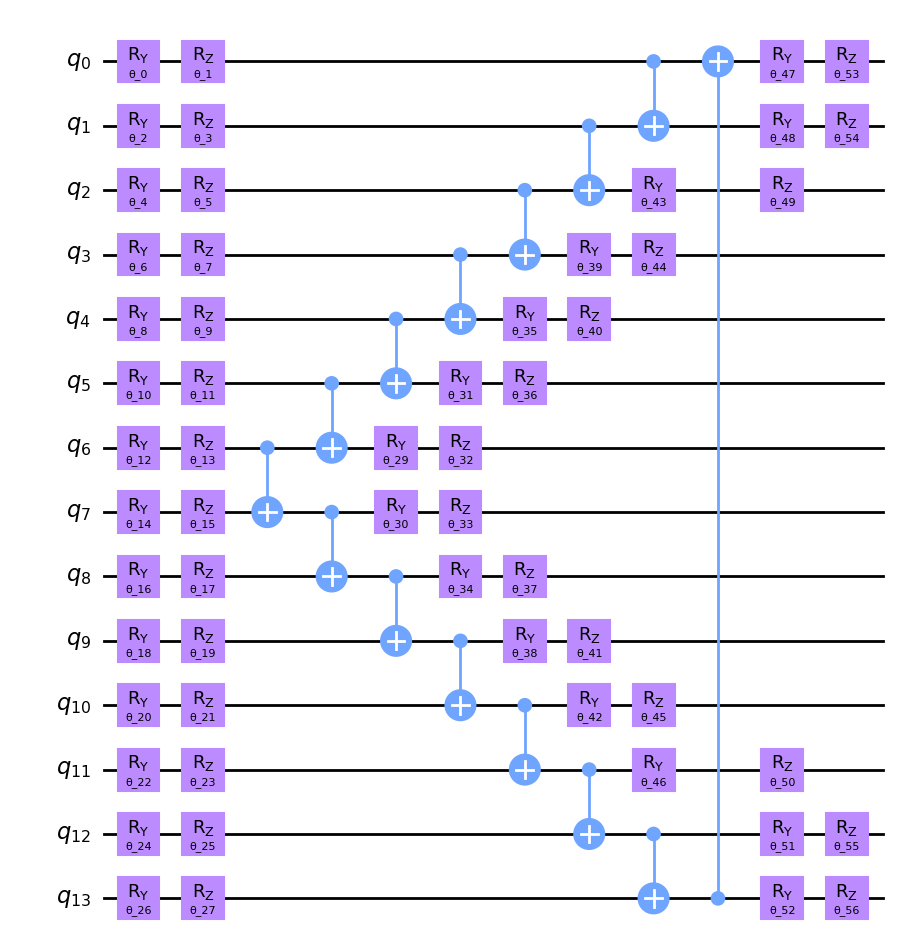

In [15]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(14)
# build initial state
# First layer
"""
ansatz_custom.h(0)
for i in range(1,14):
    ansatz_custom.cx(i-1,i)
ansatz_custom.barrier()"""
j = 0
for i in range(14):
    ansatz_custom.ry(Parameter('θ_' +str(j)), i)
    j += 1
    ansatz_custom.rz(Parameter('θ_' +str(j)), i)
    j += 1
ansatz_custom.cx(6,7)
ansatz_custom.cx(5,6)
ansatz_custom.cx(7,8)

ansatz_custom.cx(4,5)
ansatz_custom.ry(Parameter('θ_' +str(29)), 6)
ansatz_custom.ry(Parameter('θ_' +str(30)), 7)
ansatz_custom.cx(8,9)

ansatz_custom.cx(3,4)
ansatz_custom.ry(Parameter('θ_' +str(31)), 5)
ansatz_custom.rz(Parameter('θ_' +str(32)), 6)
ansatz_custom.rz(Parameter('θ_' +str(33)), 7)
ansatz_custom.ry(Parameter('θ_' +str(34)), 8)
ansatz_custom.cx(9,10)

ansatz_custom.cx(2,3)
ansatz_custom.ry(Parameter('θ_' +str(35)), 4)
ansatz_custom.rz(Parameter('θ_' +str(36)), 5)
ansatz_custom.rz(Parameter('θ_' +str(37)), 8)
ansatz_custom.ry(Parameter('θ_' +str(38)), 9)
ansatz_custom.cx(10,11)

ansatz_custom.cx(1,2)
ansatz_custom.ry(Parameter('θ_' +str(39)), 3)
ansatz_custom.rz(Parameter('θ_' +str(40)), 4)
ansatz_custom.rz(Parameter('θ_' +str(41)), 9)
ansatz_custom.ry(Parameter('θ_' +str(42)), 10)
ansatz_custom.cx(11,12)

ansatz_custom.cx(0,1)
ansatz_custom.ry(Parameter('θ_' +str(43)), 2)
ansatz_custom.rz(Parameter('θ_' +str(44)), 3)
ansatz_custom.rz(Parameter('θ_' +str(45)), 10)
ansatz_custom.ry(Parameter('θ_' +str(46)), 11)
ansatz_custom.cx(12,13)
 
ansatz_custom.cx(13,0)

ansatz_custom.ry(Parameter('θ_' +str(47)), 0)
ansatz_custom.ry(Parameter('θ_' +str(48)), 1)
ansatz_custom.rz(Parameter('θ_' +str(49)), 2)
ansatz_custom.rz(Parameter('θ_' +str(50)), 11)
ansatz_custom.ry(Parameter('θ_' +str(51)), 12)
ansatz_custom.ry(Parameter('θ_' +str(52)), 13)

ansatz_custom.rz(Parameter('θ_' +str(53)), 0)
ansatz_custom.rz(Parameter('θ_' +str(54)), 1)
ansatz_custom.rz(Parameter('θ_' +str(55)), 12)
ansatz_custom.rz(Parameter('θ_' +str(56)), 13)

ansatz_custom.draw(fold=250)

In [13]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

hub = "ibm-q"
group = "open"
project = "main"

backend_name = "ibmq_qasm_simulator"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

number and type of gates in the cirucit: OrderedDict([('ry', 28), ('rz', 28), ('cx', 14)])
number of parameters in the circuit: 56


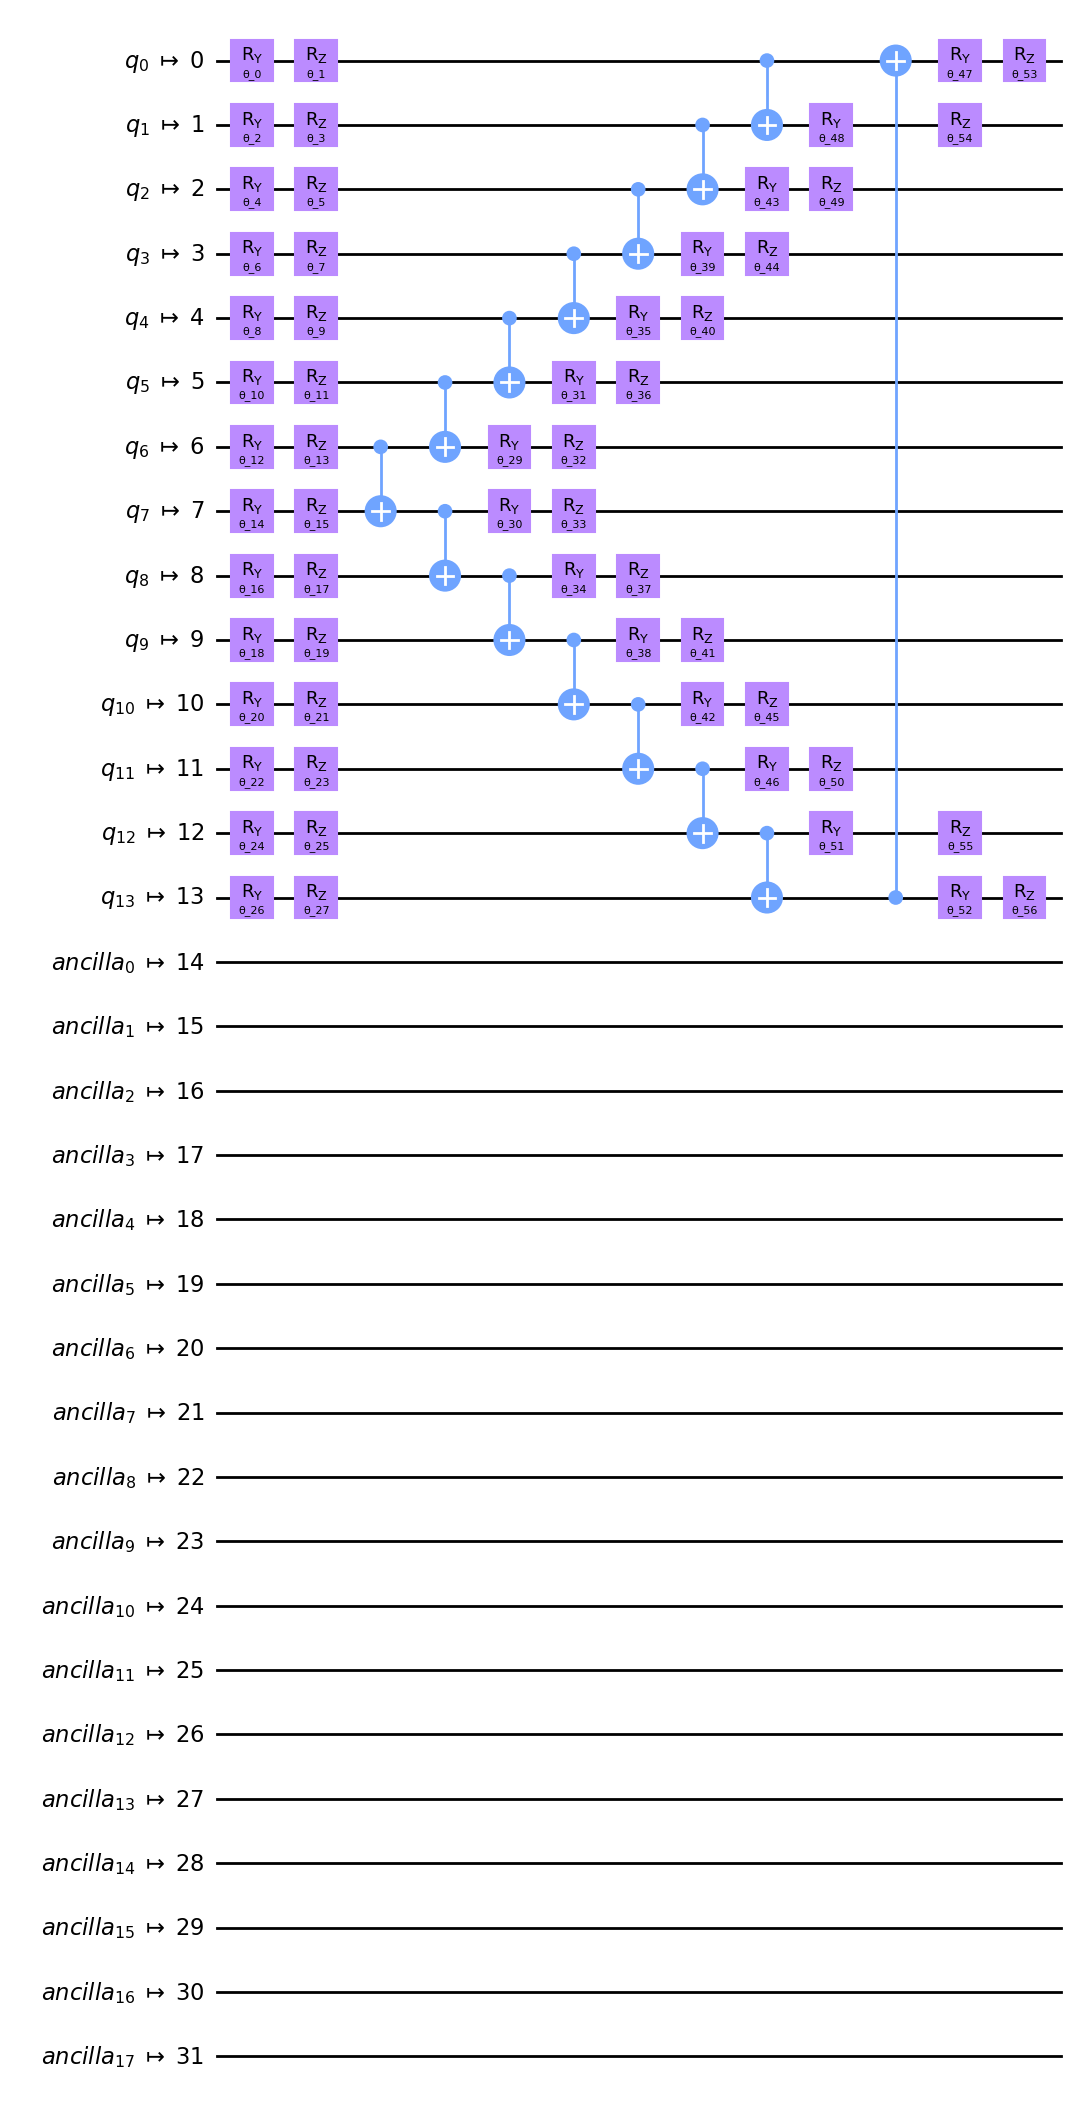

In [16]:
q_layout = [i for i in range(14)]
ansatz_opt = transpile(ansatz_custom, backend=backend, initial_layout=q_layout)
print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=250)

In [18]:
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=100)

In [19]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 *np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [20]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel='ibm_quantum')

# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'ibmq_qasm_simulator'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>]


In [21]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [22]:
import signal, time

from qiskit_ibm_runtime import Estimator, Session
from qiskit.providers import JobStatus

def timeout_handler(signum, frame):
    raise Exception('Iteration timed out')
    
class RetryEstimator(Estimator):
    """RuntimeRetryEstimator class.
    
    This class inherits from Qiskit IBM Runtime's Estimator and overwrites its run method such that it retries calling it
    a maximum of 'max_retries' consecutive times, if it encounters one of the following randomly occuring errors:
    
    * An Estimator error (in this case "Job.ERROR" is printed, and the job is cancelled automatically)
    * A timeout error where the job either remains running or completes but does not return anything, for a time larger 
      than 'timeout' (in this case the job is cancelled by the patch and "Job.CANCELLED" is printed)
    * A creation error, where the job fails to be created because connection is lost between the runtime server and the
      quantum computer (in this case "Failed to create job." is printed). If this error occurs, the patch connects the user
      to a new Session (to be handled with care! also, this will unfortunately put the next job in the queue). 
    """
    
    def __init__(self, *args, max_retries: int = 5, timeout: int = 3600, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.max_retries = max_retries
        self.timeout = timeout
        self.backend = super().session._backend
        signal.signal(signal.SIGALRM, timeout_handler)
    
    def run(self, circuits, observables, parameter_values, **kwargs):
        result = None
        for i in range(self.max_retries):
            try:
                job = super().run(circuits, observables, parameter_values, **kwargs)
                while job.status() in [JobStatus.INITIALIZING, JobStatus.QUEUED, JobStatus.VALIDATING]:
                    time.sleep(5) # Check every 5 seconds whether job status has changed
                signal.alarm(self.timeout) # Once job starts running, set timeout to 1 hour by default
                result = job.result()
                if result is not None:
                    signal.alarm(0) # reset timer
                    return job
            except Exception as e:
                print("\nSomething went wrong...")
                print(f"\n\nERROR MESSAGE:\n{e}\n\n")
                if 'job' in locals(): # Sometimes job fails to create
                    print(f"Job ID: {job.job_id}. Job status: {job.status()}.")
                    if job.status() not in [JobStatus.DONE, JobStatus.ERROR, JobStatus.CANCELLED]:
                        job.cancel()
                else:
                    print("Failed to create job.")
                print(f"Starting trial number {i+2}...\n")
                print(f"Creating new session...\n")
                signal.alarm(0) # reset timer
                super().session.close()
                self._session = Session(backend=self.backend)
        if result is None:
            raise RuntimeError(f"Program failed! Maximum number of retries ({self.max_retries}) exceeded")


### <h1>The NEXT CELL will start running your VQE Model in simulator or backend as you specified.<h1/>

In [23]:
# Setup Estimator with session error handling reconnection work around
start = time.time()
with Session(service=service, backend=backend) as session:
    # Prepare extended primitive
    rt_estimator = RetryEstimator(session=session)
    # set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_25)
end = time.time()
print(f'execution time (s): {end - start:.2f}')

base_primitive._run_primitive:INFO:2023-12-29 05:26:52,747: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_transpilation': False, 'initial_layout': None, 'layout_method': None, 'routing_method': None, 'approximation_degree': None, 'optimization_settings': {'level': 1}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'noise_amplifier': 'TwoQubitAmplifier', 'noise_factors': (1, 3, 5), 'extrapolator': 'LinearExtrapolator', 'level': 0}, 'execution': {'shots': 4000, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'callback': None, 'job_tags': []}, 'simulator': {'noise_model': None, 'seed_simulator': None, 'coupling_map': None, 'basis_gates': None}}
base_primitive._run_primitive:INFO:2023-12-29 05:26:56,191: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'max_execution_time': None, 'transpilation': {'skip_trans

execution time (s): 896.96


/tmp/ipykernel_205/621667138.py:35: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQEResult``. See https://qisk.it/algo_migration for a migration guide.
  result = VQEResult()


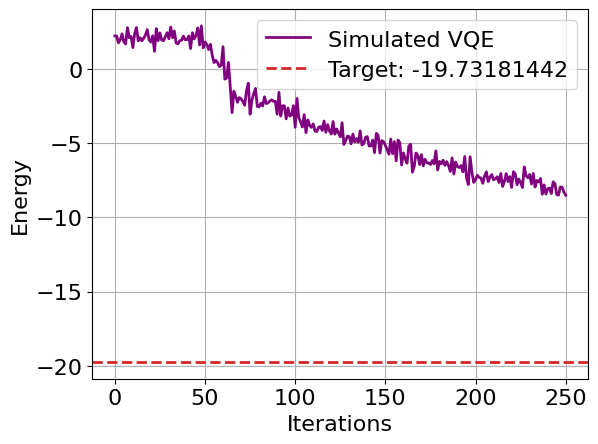

In [24]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [25]:
print(f'Computed ground state energy: {result.eigenvalue:.10f}')

Computed ground state energy: -8.5215000000
